I don't know about you, but fitness tracking software is at the intersection of two of my favorite things: being active and data. The purpose of this project is to calculate a valuable metric at the end of your workouts: how many calories you burned! The model uses information that could be collected during your workout and information about your health in general in order to make its predictions. Let's see it in action!

In [1]:
#imports
import prepare as p
import explore as e
import model as m

The data was investigated upon acquisition. I found no null values and each field was the correct datatype. I removed a number of features from the dataset because they would be difficult/impossible to calculate during a workout, they were strongly correlated with another feature (BMI and weight), or they were categorical and therefore difficult for the regression problem. Cleaning the data left me with this dataset:

In [2]:
df = p.prepare_data()
df.head()

Data found.


,age,weight (kg),height (m),max_bpm,avg_bpm,resting_bpm,session_duration (hours),calories_burned,fat_percentage
0,56,88.3,1.71,180,157,60,1.69,1313.0,12.6
1,46,74.9,1.53,179,151,66,1.30,883.0,33.9
2,32,68.1,1.66,167,122,54,1.11,677.0,33.4
3,25,53.2,1.70,190,164,56,0.59,532.0,28.8
4,38,46.1,1.79,188,158,68,0.64,556.0,29.2


I'll split the data into train, validate, and test, so the exploration portion of my project is solely over the train subset. This prevents data leakage from the other subsets into my analysis.

In [3]:
train, val, test = p.split_data(df)

Data split.


Let's explore the data! I'll start with the distribution of the target variable, calories burned.

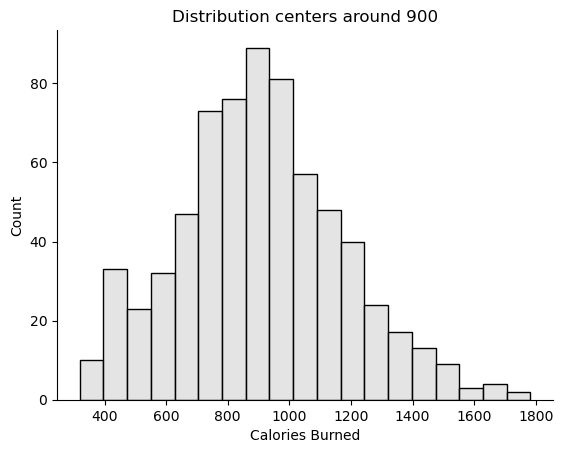

In [4]:
e.targ_fig(train)

The data appears to be ~approximately normally distributed, with many of the workouts burning from 700 to 1000 calories. That's motivating!

Next, I'll take a look at how a few of the features interact with the target variable. I entered my exploration with 3 main questions on my mind.
1. Does the workout duration affect the number of calories burned?
2. Does the fat percentage of the individual affect how many calories they burn in a workout?
3. Does the average BPM (heartrate) of the individual affect the number of calories burned?

Question 1: Does the workout duration affect the number of calories burned?

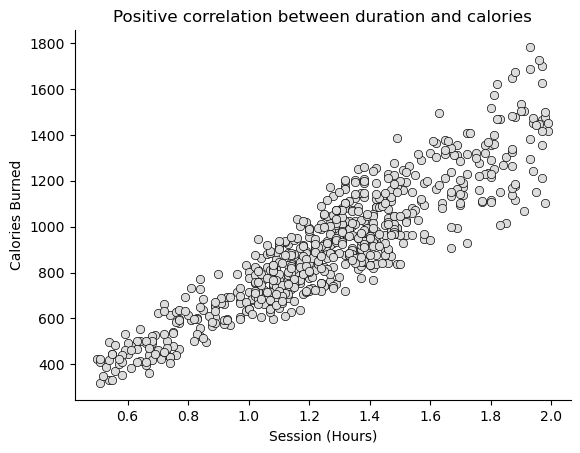

In [5]:
e.duration_fig(train)

Yes, there is a strong, positive correlation between the two. Extending a workout session looks like a clear way to burn more calories.

Question 2: Does the fat percentage of the individual affect how many calories they burn in a workout?

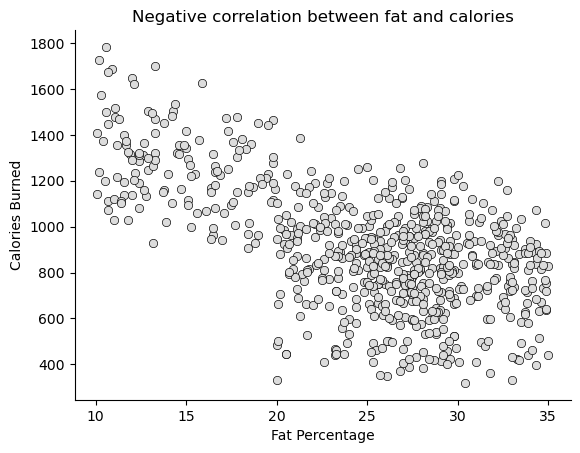

In [6]:
e.fat_fig(train)

Yes, there appears to be a relationship between the two. As fat percentage increases, the number of calories burned decreases. It's interesting that the people who are burning the most calories in a workout have the lowest fat percentage.

Question 3: Does the average BPM (heartrate) of the individual affect the number of calories burned?

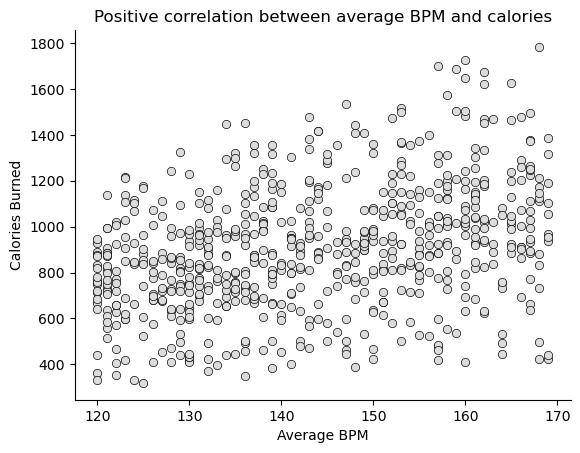

In [7]:
e.bpm_fig(train)

There appears to be a slight positive correlation between the two. Maintaining a heart rate that high for an entire workout can be very uncomfortable but it looks like it may pay off!

After exploring some of the trends in my data, I moved on to the modeling part of the project. Before jumping into modeling, it was important for me to complete two tasks!
1. Scaling the data. Since this is a regression problem and I have features on wildly different scales (BPM values exceeding 180 and durations that are less than 1), the model could become biased toward certain features if they remain on different scales. I scaled all features, leaving the target variable untouched.
2. Splitting the data into X and y. I have to make sure I don't train my model on the target variable! Otherwise, the results would be a little too good..  

I'll handle these tasks in the next couple code cells.

In [8]:
train, val, test = p.scale_data(train, val, test)

Data scaled.


In [9]:
X_train, y_train, X_val, y_val, X_test, y_test = p.xy_split(train, val, test)
X_train.head()

X and y created.


,age,weight (kg),height (m),max_bpm,avg_bpm,resting_bpm,session_duration (hours),fat_percentage
514,1.161771,-0.252634,-1.378424,-1.362717,-0.869317,0.374838,0.438446,0.175000
583,0.500951,-1.533736,-1.143590,1.305959,1.689882,1.186490,0.616864,0.589079
926,0.005337,1.376127,1.674408,1.047700,-0.661815,-1.654293,-1.107840,-0.334635
850,0.748759,-0.205010,-0.987035,0.961613,1.551547,-1.248467,0.230292,0.175000
423,0.335747,1.071330,0.969908,0.531182,0.929039,0.239563,0.051875,0.429818


As you can see, the features are scaled and the target variable is removed from the X datasets.

Before creating and testing my own models, I made sure to define a baseline for the project. I tested the mean and the median for the y_train subset. I chose to use the mean because the error was lower.

I chose root mean squared error as the error metric because I like that it's in the same units as the target variable. It makes for an interpretable result. All expressions of error will be in root mean squared error.

In [10]:
baseline = m.get_baseline(y_train)

Baseline calculated.
Baseline: 268.24


The baseline has an RMSE of about 270. The number means that if we guess the mean of the dataset every time, we're off by 270 calories on average. The goal of the modeling section is to beat the baseline by producing a lower RMSE.

I tried three different kinds of linear models: the basic linear regression model, a linear regression model with lasso (l1) regularization, and a linear regression model with ridge (l2) regularization. You can see some of this work in the initial_model.ipynb notebook. I found that the linear regression model outperformed the other two on the train and validation sets. As a result, I elected to move forward with the basic linear regression model to use on my test set. This will be the best estimation of how this model will perform in the wild.

In [11]:
test_rmse = m.make_preds(X_train, y_train, X_val, y_val, X_test, y_test)

Predictions evaluated.
Train RMSE: 48.05.
Validation RMSE: 48.46.
Test RMSE: 47.3.


Our model's RMSE is much lower than the baseline, indicating that this model is a great improvement over random guessing. I'll create a visual of the difference in the final plot.

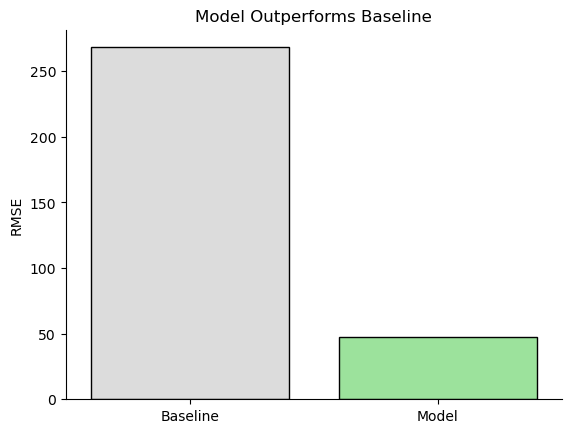

In [12]:
m.visualize(baseline, test_rmse)

As you can see, the error associated with our model's predictions is much lower than that of the baseline. We can interpret the test RMSE of 47 by saying that on average, the model's prediction is wrong by 47 calories. When most of the workouts are burning anywhere from 700 to 1000 calories, this is a decently small margin of error!

In conclusion, I achieved the goal set for this project. I was able to use features we could collect about somebody's workout in order to predict how many calories they would burn. The best model ended up being the simplest: the linear regression model was able to predict calories burned with an RMSE of 47. Being this close to the mark, I would recommend this model to be used in production environments.

I would like my future work on this project to focus on a couple of areas. My first would be trying different combinations of features. My existing model was trained on the scaled, original features: could my model performance improve with some feature engineering? The second area of focus would be looking at additional pieces of information we could include in the dataset. Are there more features that could improve model performance? I may be able to improve upon my work here by answering these questions.